In [137]:
from PIL import Image
from IPython.display import Image as DPImage
import os
import numpy as np
from random import sample

### Extracting Masks From RLE
Extract and store Masks for validation set from RLE encoding
(This is necessary for the validation set as we only have run length encoded masks for this dataset)

In [199]:
import csv

RLE_encodings_file = "./data/stage1_solution.csv"
data_dir = "./data/stage1_test"

with open(RLE_encodings_file, newline='') as csvfile:
    for i, (imgID, RLE, H, W, _) in enumerate(csv.reader(csvfile, delimiter=',')):
        if i == 0: # Skip row with labels
            continue
        H, W = int(H), int(W)
        img = Image.new(mode='1', size=(W, H))
        pixels = img.load()
        RLE_split = list(map(lambda x: int(x), RLE.split()))
        for RLE_i in range(0, len(RLE_split), 2):
            start, length = RLE_split[RLE_i:RLE_i+2]
            for x in range(start, start + length):
                pixels[(x-1)//H, (x-1)%H] = 1

        # Save Mask
        p = f"{data_dir}/{imgID}/masks"
        if not os.path.exists(p):
            os.mkdir(p)
        img.save(f"{p}/mask_{i}.png")


### Create Combined Masks
The model requires the combined masks for each image as label.

In [175]:
# merge a list of masks (arrays) into one mask
def merge_masks(masks):
    # check dimensions
    dim = masks[0].size
    if not all(map(lambda m: m.size == dim, masks)):
        raise AssertionError("All masks must have the same dimensions")

    msum = np.asarray(Image.new(mode='1', size=dim))
    for m in masks:
        msum = np.ma.mask_or(msum, np.asarray(m))
    im = Image.fromarray(msum)
    
    return im

In [201]:
def create_combined_masks(data_directory):
    for img_dir in os.listdir(data_directory):
        p = f"{data_directory}/{img_dir}/combined_masks"
        if not os.path.exists(p):
            os.mkdir(p)
        merge_masks(list(map(
            lambda m: Image.open(f"{data_directory}/{img_dir}/masks/{m}").convert("1"), 
            os.listdir(f"{data_directory}/{img_dir}/masks")
        ))).save(f"{p}/{img_dir}.png")

create_combined_masks("./data/stage1_test")
create_combined_masks("./data/stage1_train")

## Data Exploration
Now we have all the data we can visualize it

670 Training Images

Image:
573a657d5e5fcb9574a758b0ab34b09c79d7ba374ceb71227c3dc88f009a3f6b.png


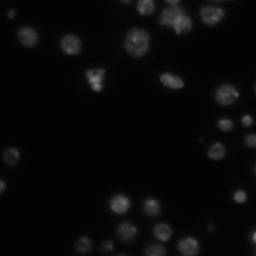

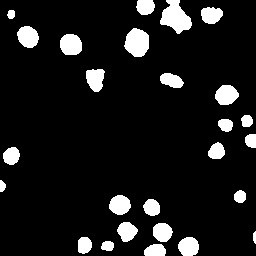

Image:
2c83c86dd4e5dacc024b55629375567fb8e320a82ef86f541cfe54764040fc25.png


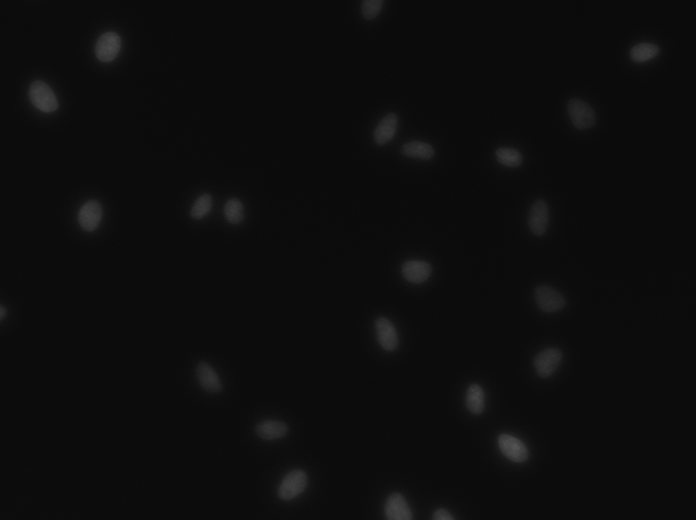

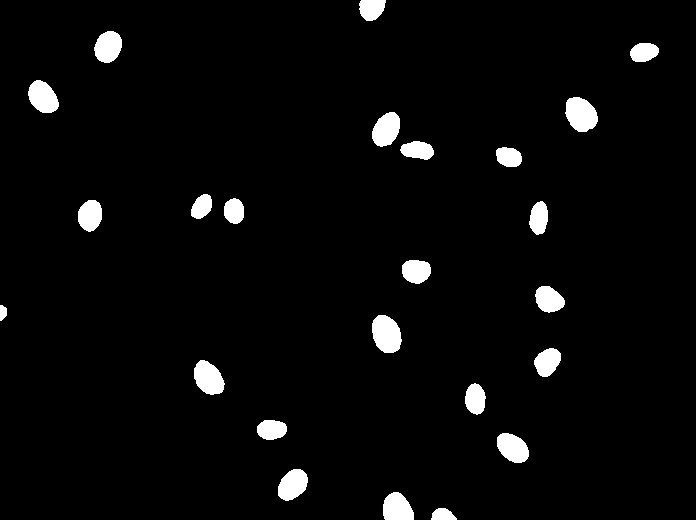

Image:
9520aff4efe87bd8f3901652fa2dde9b4bc9c679325966145ce00c1ca33f35de.png


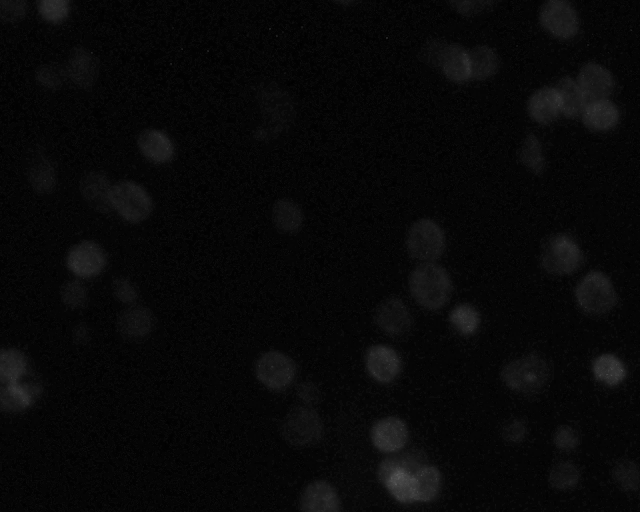

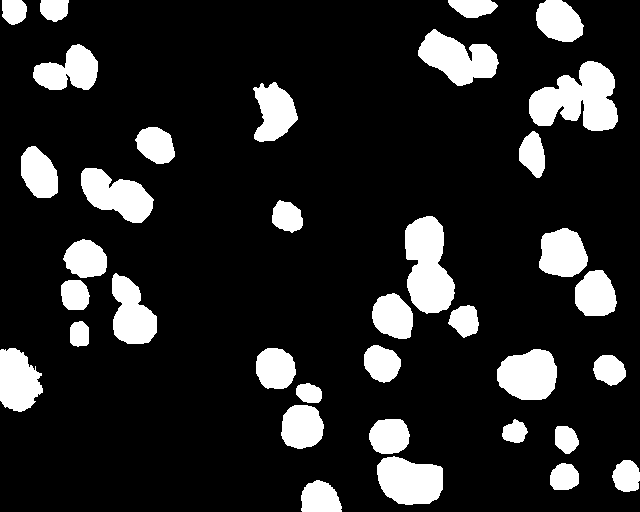

Image:
da5f98f2b8a64eee735a398de48ed42cd31bf17a6063db46a9e0783ac13cd844.png


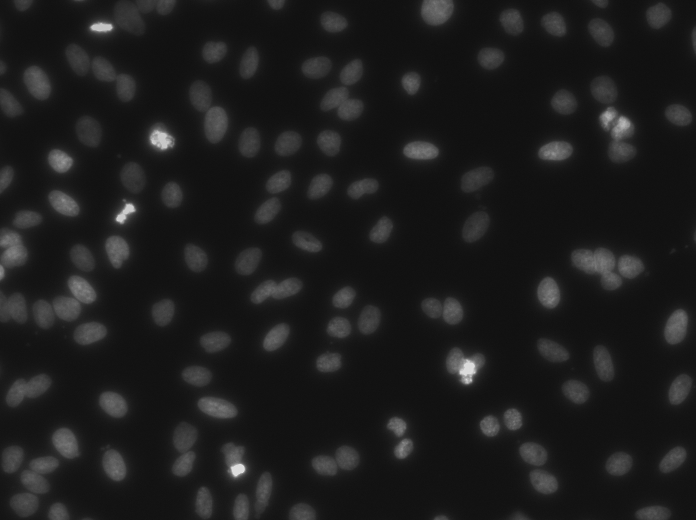

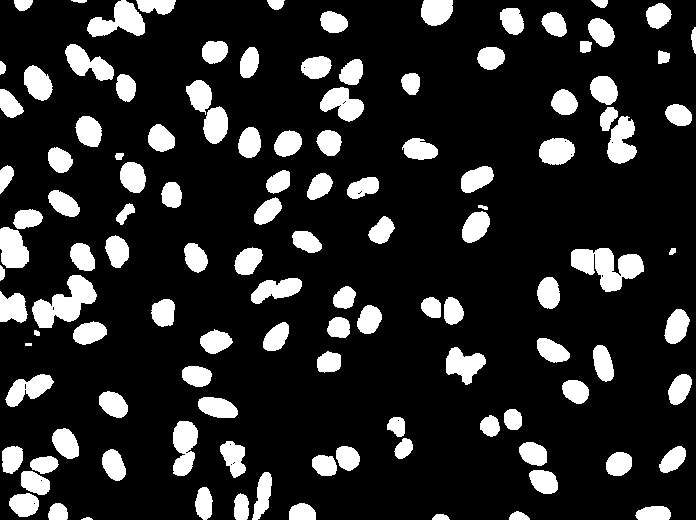

Image:
15039b3acccc4257a1a442646a89b6e596b5eb4531637e6d8fa1c43203722c99.png


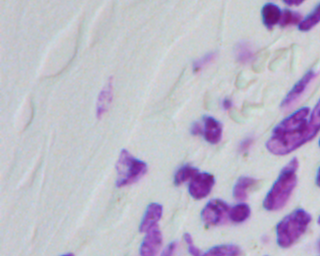

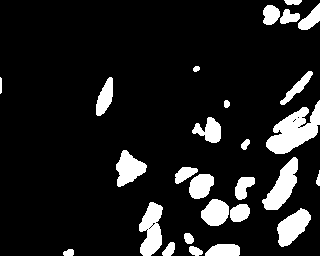

Image:
04acab7636c4cf61d288a5962f15fa456b7bde31a021e5deedfbf51288e4001e.png


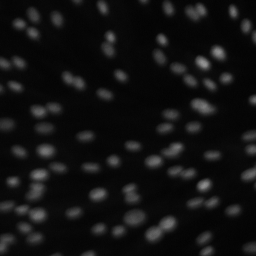

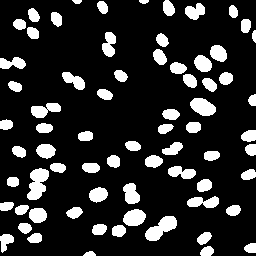

Image:
243443ae303cc09cfbea85bfd22b0c4f026342f3dfc3aa1076f27867910d025b.png


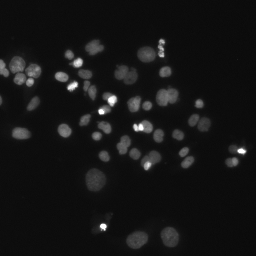

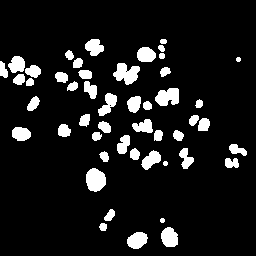

Image:
1e61ecf354cb93a62a9561db87a53985fb54e001444f98112ed0fc623fad793e.png


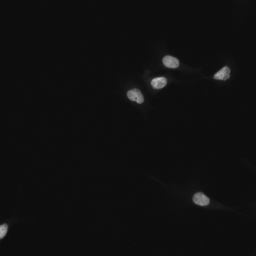

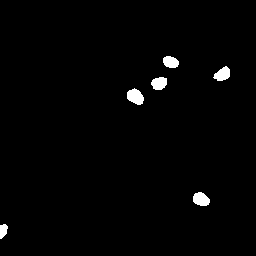

Image:
f20eb4592e7d3cf58d421a9c34832d33adcdcbd0e17b7bf009a013847608da27.png


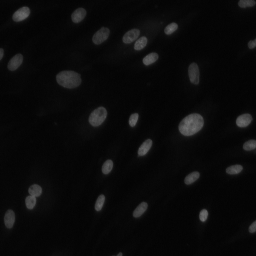

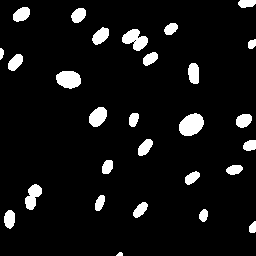

Image:
700afb1cd830a808e3c6125749612e5d23fd9f9726049a9e0c2061997514e1a7.png


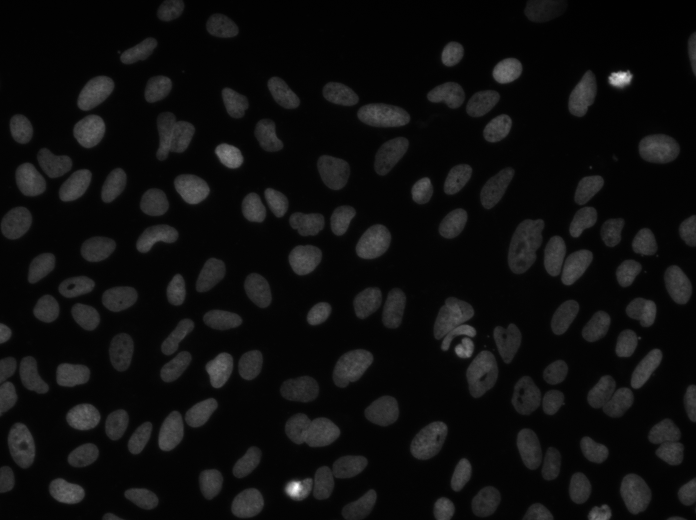

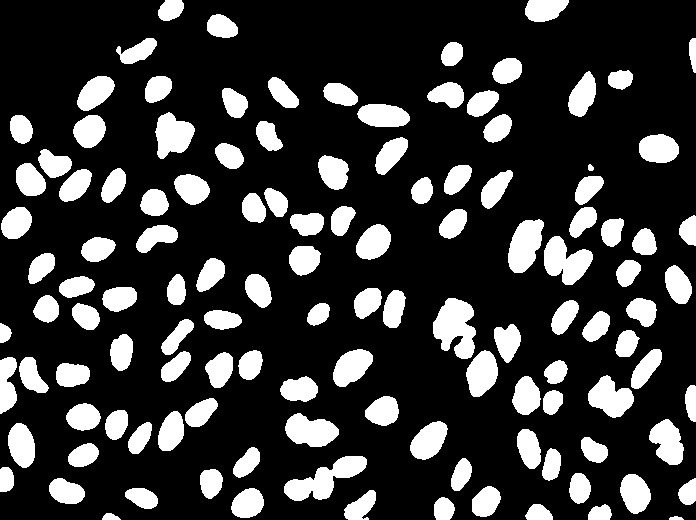

In [205]:
data_dir = "./data/stage1_train"
images_print_amount = 10


tags = os.listdir(data_dir)
print(f"{len(tags)} Training Images")
print()

for i in sample(range(len(tags)), images_print_amount):

    print("Image:")
    path = f"{data_dir}/{tags[i]}/images"
    filename = os.listdir(path)[0]
    print(filename)
    display(DPImage(filename=f"{path}/{filename}"))

    path = f"{data_dir}/{tags[i]}/combined_masks"
    filename = os.listdir(path)[0]
    display(DPImage(filename=f"{path}/{filename}"))